# Wind Power estimation

### Dependencies

In [1]:
import pandas as pd
import pandas.util.testing as tm
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn import metrics
from sklearn.metrics import mean_squared_error 
from math import sqrt
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.



### Importing Data and EDA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Deep/winddataf.csv', encoding= 'unicode_escape')
data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,WSF2,WSF5,LV ActivePower (kW),Wind speed (V),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,USW00014753,"BLUE HILL LCD, MA US",42.2123,-71.1137,190.5,01-07-2015,10.7,13.4,380.047790,5.311336,416.328908,259.994904
1,USW00014753,"BLUE HILL LCD, MA US",42.2123,-71.1137,190.5,02-07-2015,8.1,10.3,453.769196,5.672167,519.917511,268.641113
2,USW00014753,"BLUE HILL LCD, MA US",42.2123,-71.1137,190.5,03-07-2015,5.8,7.6,306.376587,5.216037,390.900016,272.564789
3,USW00014753,"BLUE HILL LCD, MA US",42.2123,-71.1137,190.5,04-07-2015,5.4,7.2,419.645904,5.659674,516.127569,271.258087
4,USW00014753,"BLUE HILL LCD, MA US",42.2123,-71.1137,190.5,05-07-2015,6.7,8.9,380.650696,5.577941,491.702972,265.674286


In [4]:
data.dropna(subset = ['ELEVATION', 'Wind speed (V)', 'WSF5', 'WSF2', 'Wind Direction (°)'])
data.dropna(subset = ['Wind speed (V)'])

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,WSF2,WSF5,LV ActivePower (kW),Wind speed (V),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,01-07-2015,10.7,13.4,380.047790,5.311336,416.328908,259.994904
1,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,02-07-2015,8.1,10.3,453.769196,5.672167,519.917511,268.641113
2,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,03-07-2015,5.8,7.6,306.376587,5.216037,390.900016,272.564789
3,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,04-07-2015,5.4,7.2,419.645904,5.659674,516.127569,271.258087
4,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,05-07-2015,6.7,8.9,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...,...,...,...,...,...,...,...
2749,USW00004780,"FITCHBURG MUNICIPAL AIRPORT, MA US",42.55194,-71.75583,106.1,27-12-2015,9.8,13.4,3602.979004,19.919359,3600.000000,200.174805
2750,USW00004780,"FITCHBURG MUNICIPAL AIRPORT, MA US",42.55194,-71.75583,106.1,28-12-2015,9.8,13.0,3602.931885,19.313379,3600.000000,202.396103
2751,USW00004780,"FITCHBURG MUNICIPAL AIRPORT, MA US",42.55194,-71.75583,106.1,29-12-2015,7.6,9.8,3603.333008,18.495939,3600.000000,203.690308
2752,USW00004780,"FITCHBURG MUNICIPAL AIRPORT, MA US",42.55194,-71.75583,106.1,30-12-2015,3.6,5.4,3603.354004,19.396940,3600.000000,203.396698


In [5]:
np.isnan(data['Wind speed (V)']).any(), np.isnan(data['WSF2']).any(), np.isnan(data['LV ActivePower (kW)']).any()

(False, False, False)

In [6]:
data['DATE'] = pd.to_datetime(data['DATE'].astype(str), format='%d-%m-%Y')

data['MONTH'] = pd.DatetimeIndex(data['DATE']).month
data

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,WSF2,WSF5,LV ActivePower (kW),Wind speed (V),Theoretical_Power_Curve (KWh),Wind Direction (°),MONTH
0,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,2015-07-01,10.7,13.4,380.047790,5.311336,416.328908,259.994904,7
1,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,2015-07-02,8.1,10.3,453.769196,5.672167,519.917511,268.641113,7
2,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,2015-07-03,5.8,7.6,306.376587,5.216037,390.900016,272.564789,7
3,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,2015-07-04,5.4,7.2,419.645904,5.659674,516.127569,271.258087,7
4,USW00014753,"BLUE HILL LCD, MA US",42.21230,-71.11370,190.5,2015-07-05,6.7,8.9,380.650696,5.577941,491.702972,265.674286,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749,USW00004780,"FITCHBURG MUNICIPAL AIRPORT, MA US",42.55194,-71.75583,106.1,2015-12-27,9.8,13.4,3602.979004,19.919359,3600.000000,200.174805,12
2750,USW00004780,"FITCHBURG MUNICIPAL AIRPORT, MA US",42.55194,-71.75583,106.1,2015-12-28,9.8,13.0,3602.931885,19.313379,3600.000000,202.396103,12
2751,USW00004780,"FITCHBURG MUNICIPAL AIRPORT, MA US",42.55194,-71.75583,106.1,2015-12-29,7.6,9.8,3603.333008,18.495939,3600.000000,203.690308,12
2752,USW00004780,"FITCHBURG MUNICIPAL AIRPORT, MA US",42.55194,-71.75583,106.1,2015-12-30,3.6,5.4,3603.354004,19.396940,3600.000000,203.396698,12


### Analyzing Data

In [7]:
data.dtypes

STATION                                  object
NAME                                     object
LATITUDE                                float64
LONGITUDE                               float64
ELEVATION                               float64
DATE                             datetime64[ns]
WSF2                                    float64
WSF5                                    float64
LV ActivePower (kW)                     float64
Wind speed (V)                          float64
Theoretical_Power_Curve (KWh)           float64
Wind Direction (°)                      float64
MONTH                                     int64
dtype: object

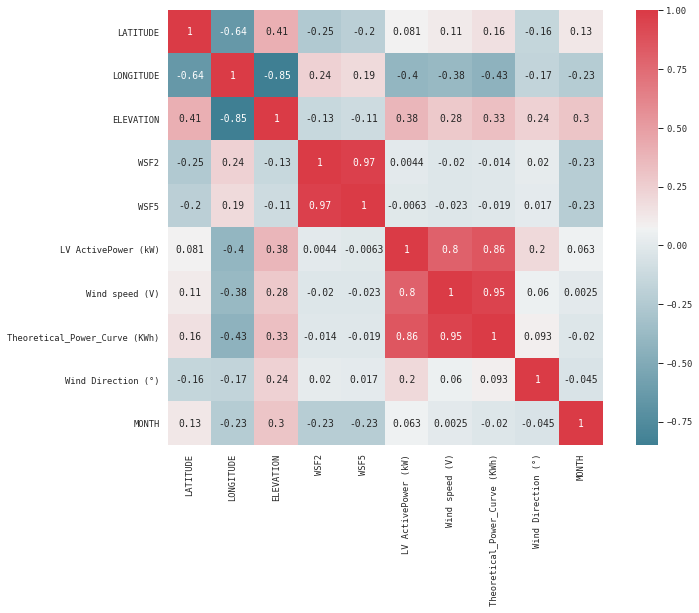

In [8]:
#heatmap using seaborn
#set the context for plotting 
sns.set(context="paper",font="monospace")
housing_corr_matrix = data.corr()
#set the matplotlib figure
fig, axe = plt.subplots(figsize=(12,8))
#Generate color palettes 
cmap = sns.diverging_palette(220,10,center = "light", as_cmap=True)
#draw the heatmap
sns.heatmap(housing_corr_matrix,vmax=1,square =True, cmap=cmap,annot=True );

In [9]:
data.isnull().sum()

STATION                          0
NAME                             0
LATITUDE                         0
LONGITUDE                        0
ELEVATION                        0
DATE                             0
WSF2                             0
WSF5                             0
LV ActivePower (kW)              0
Wind speed (V)                   0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
MONTH                            0
dtype: int64

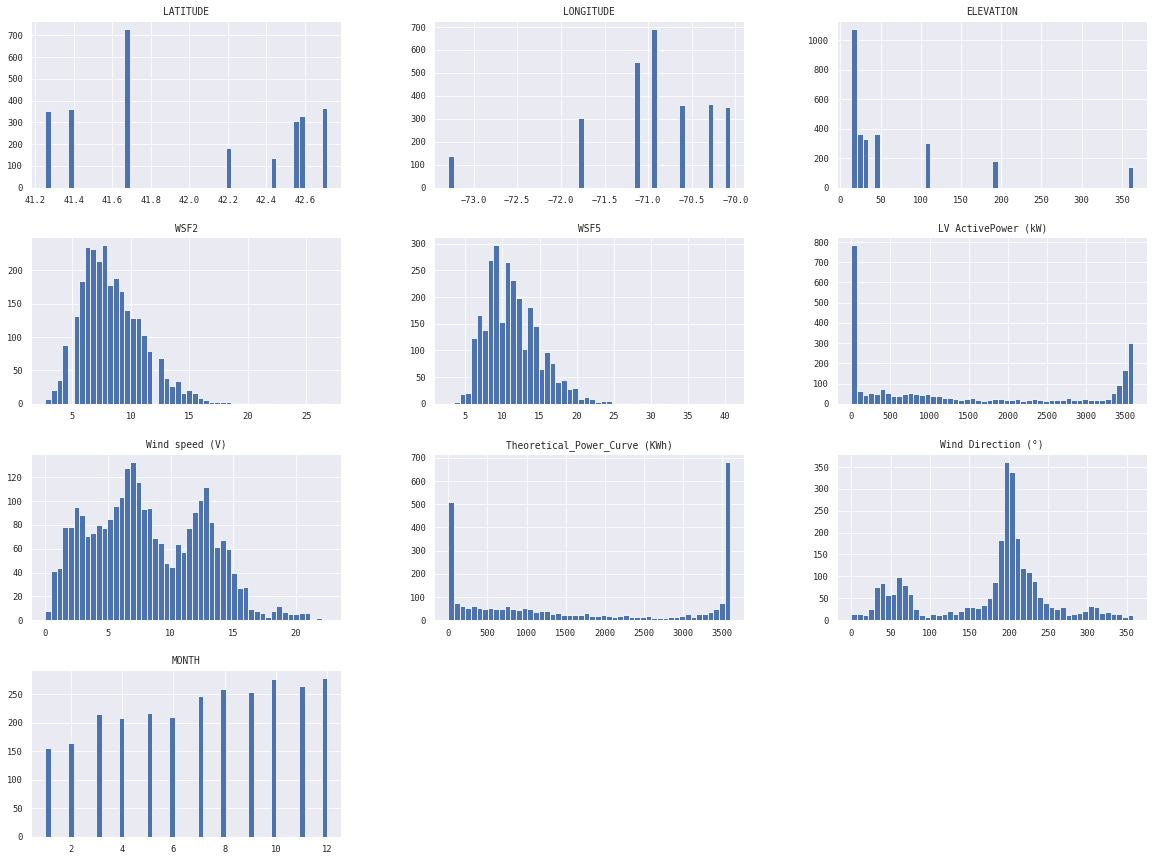

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50,figsize=(20,15))
plt.show()

Checking the ranges for the target variable 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



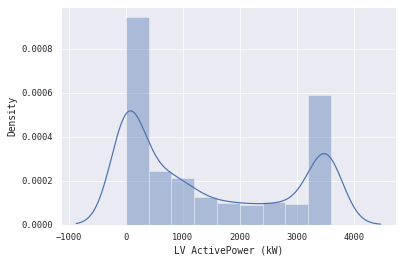

In [11]:
sns.distplot(data['LV ActivePower (kW)'],kde=True)

### Spliting data 

Split the dataset into 80% train and 20% test dataset

In [12]:
X = data[["LATITUDE", "LONGITUDE", "ELEVATION", "WSF2", "WSF5", "Wind speed (V)", "Theoretical_Power_Curve (KWh)", "Wind Direction (°)"]]
X.head()

,LATITUDE,LONGITUDE,ELEVATION,WSF2,WSF5,Wind speed (V),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,42.2123,-71.1137,190.5,10.7,13.4,5.311336,416.328908,259.994904
1,42.2123,-71.1137,190.5,8.1,10.3,5.672167,519.917511,268.641113
2,42.2123,-71.1137,190.5,5.8,7.6,5.216037,390.900016,272.564789
3,42.2123,-71.1137,190.5,5.4,7.2,5.659674,516.127569,271.258087
4,42.2123,-71.1137,190.5,6.7,8.9,5.577941,491.702972,265.674286


In [13]:
y = data["LV ActivePower (kW)"]
print("LV ActivePower (kW)")
y.head()

LV ActivePower (kW)


0    380.047790
1    453.769196
2    306.376587
3    419.645904
4    380.650696
Name: LV ActivePower (kW), dtype: float64

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [15]:
#X = data[["ELEVATION", "Wind speed (V)", "Wind Direction (°)"]]
#y = data["LV ActivePower (kW)"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
print("X_train shape {} and size {}".format(X_train.shape,X_train.size))
print("X_test shape {} and size {}".format(X_test.shape,X_test.size))
print("y_train shape {} and size {}".format(y_train.shape,y_train.size))
print("y_test shape {} and size {}".format(y_test.shape,y_test.size))

X_train shape (2203, 8) and size 17624
X_test shape (551, 8) and size 4408
y_train shape (2203,) and size 2203
y_test shape (551,) and size 551


### Standardize the Data

Feature scaling is to bring all the independent variables in a dataset into same scale, to avoid any variable dominating the model. 
Here I will not transform the dependent variables.


In [17]:
independent_scaler = StandardScaler()
X_train = independent_scaler.fit_transform(X_train)
X_test = independent_scaler.transform(X_test)
print(X_train[0:5,:])
print("test data")
print(X_test[0:5,:])

[[-1.08702713  0.44436215 -0.49289947 -0.80341963 -0.98394853 -1.05287225
  -1.15076343 -0.0752065 ]
 [ 0.40368894 -0.24708894  1.57939432 -1.13743236 -1.0886325  -0.59419565
  -0.84230505  1.23954536]
 [ 1.02170907 -1.13740673  0.54934958  0.82953149  0.90036292  0.04392626
   0.05767786  1.80692663]
 [-1.34177574  1.21272278 -0.57832972 -0.80341963 -0.64372563 -0.22950125
  -0.40840667  0.02126071]
 [ 1.322458   -0.26121744 -0.19145273 -0.98898226 -0.4081867  -0.36052249
  -0.58832247 -1.65821118]]
test data
[[-0.58562728  0.90884202 -0.54049633 -0.80341963 -0.7484096  -0.52599671
  -0.77609102 -1.33304611]
 [-0.57147054 -0.03166733 -0.44774348  0.34706866  0.42928506  0.54932121
   0.98242141  0.37248286]
 [ 1.322458   -0.26121744 -0.19145273 -0.3209568  -0.4081867   0.01539312
   0.0043624  -1.40974086]
 [-0.58562728  0.90884202 -0.54049633  0.34706866  0.06289116 -0.8071785
  -1.01235341  0.5394757 ]
 [-1.34177574  1.21272278 -0.57832972 -0.3209568  -0.64372563 -0.64144922
  -0.88

### Models

I used three different models to predict result. To evaluate which one is the best, I used three different metrics to evaluate our models; mean_squared_error,mean_absolute_error, and explained_variance_score.

- **mean_squared_error** : It tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The squaring is necessary to remove any negative signs. It also gives more weight to larger differences. It’s called the mean squared error as you’re finding the average of a set of errors.

- **mean_absolute_error** : It is a measure of errors between paired observations expressing the same phenomenon.

- **explained_variance_score** : It is used to measure the discrepancy between a model and actual data.

#### Random Forest Regression

In [18]:
from sklearn.ensemble import RandomForestRegressor
regressor1 = RandomForestRegressor(max_depth= 10, max_leaf_nodes= 25,n_estimators=50)
regressor1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=25,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [19]:
y_pred_1 = regressor1.predict(X_test)

In [20]:
print(mean_absolute_error(y_test,y_pred_1))
print(np.sqrt(mean_squared_error(y_test,y_pred_1)))
print(explained_variance_score(y_test,y_pred_1))

203.96388219836447
438.24994884209093
0.9011568817308114


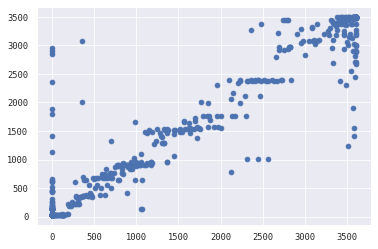

In [21]:
plt.scatter(y_test,y_pred_1)

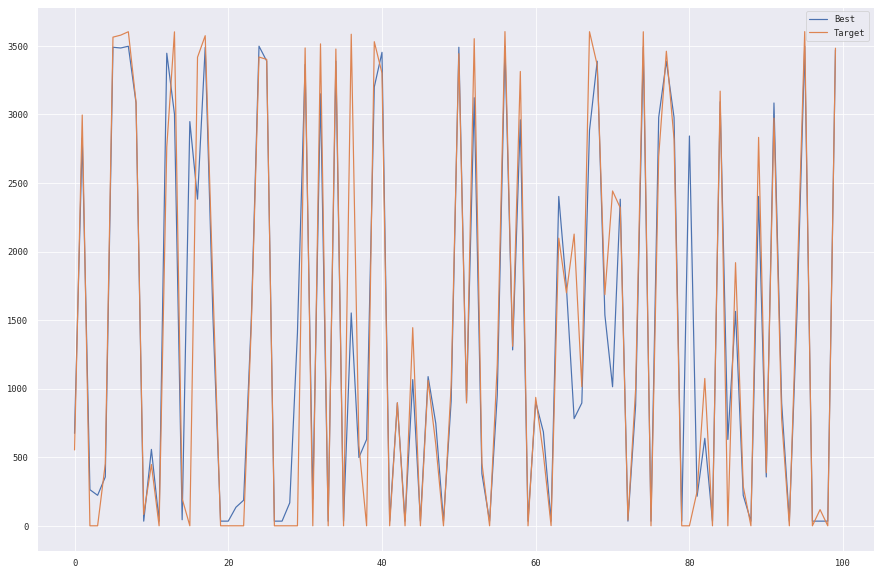

In [22]:
rfr_table = pd.DataFrame({'Predict_values':y_pred_1,'Actual_values':y_test})
fig= plt.figure(figsize=(15,10))
predicting_vs_actual_rfr = rfr_table.reset_index()
predicting_vs_actual_rfr = predicting_vs_actual_rfr.drop(['index'],axis=1)
plt.plot(predicting_vs_actual_rfr[:100])
plt.legend(('Best', 'Target'))

#### Decision Tree Regression

In [23]:
from sklearn.tree import DecisionTreeRegressor
regressor2 = DecisionTreeRegressor(max_depth= 7, max_leaf_nodes= 50)
regressor2.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=50,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [24]:
y_pred_2 = regressor2.predict(X_test)

In [25]:
print(mean_absolute_error(y_test,y_pred_2))
print(np.sqrt(mean_squared_error(y_test,y_pred_2)))
print(explained_variance_score(y_test,y_pred_2))

177.10515125840445
441.2307033304903
0.8999730935619109


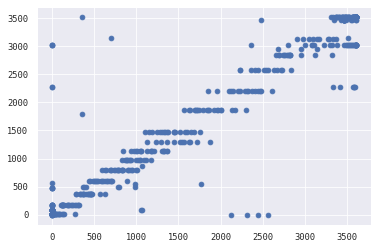

In [26]:
plt.scatter(y_test,y_pred_2)

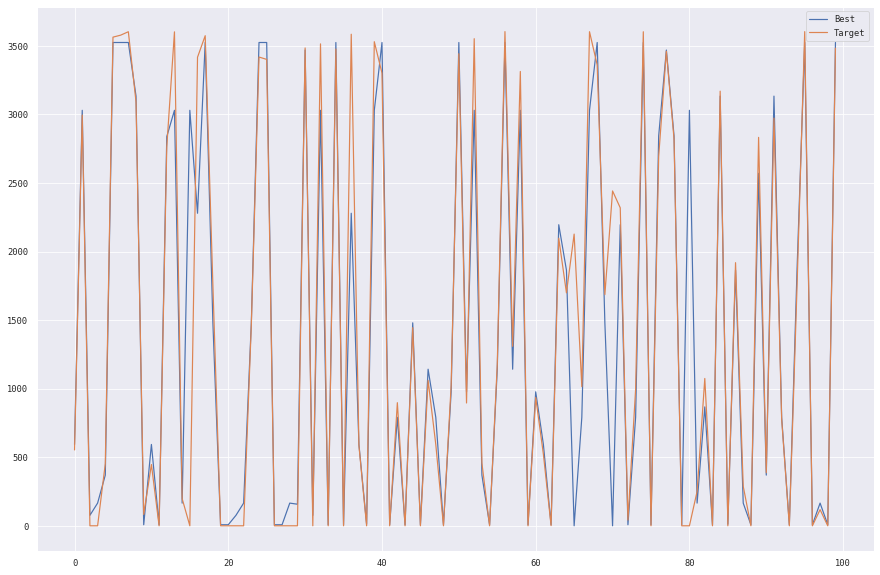

In [27]:
# Comparison of Target value vs Predicted values
dtr_table = pd.DataFrame({'Predict_values':y_pred_2,'Actual_values':y_test})
fig= plt.figure(figsize=(15,10))
predicting_vs_actual_dtr = dtr_table.reset_index()
predicting_vs_actual_dtr = predicting_vs_actual_dtr.drop(['index'],axis=1)
plt.plot(predicting_vs_actual_dtr[:100])
plt.legend(('Best', 'Target'))

#### Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression
regressor3 = LinearRegression(n_jobs=-3)
regressor3.fit(X_train, y_train)
print("Intercept is "+str(regressor3.intercept_))
print("coefficients is "+str(regressor3.coef_))

Intercept is 1449.8647238442236
coefficients is [ -99.99693318   75.75386627  218.71744924   86.96360681  -93.24393206
 -136.03221237 1303.9573462   109.50008748]


In [29]:
y_pred_3 = regressor3.predict(X_test)

In [30]:
print(mean_absolute_error(y_test,y_pred_3))
print(np.sqrt(mean_squared_error(y_test,y_pred_3)))
print(explained_variance_score(y_test,y_pred_3))

384.5795311613155
645.9550165807535
0.7852645218907319


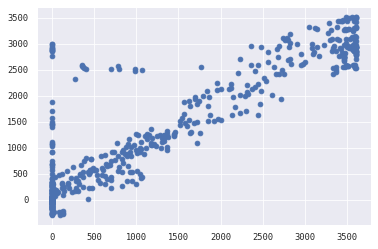

In [31]:
plt.scatter(y_test,y_pred_3)

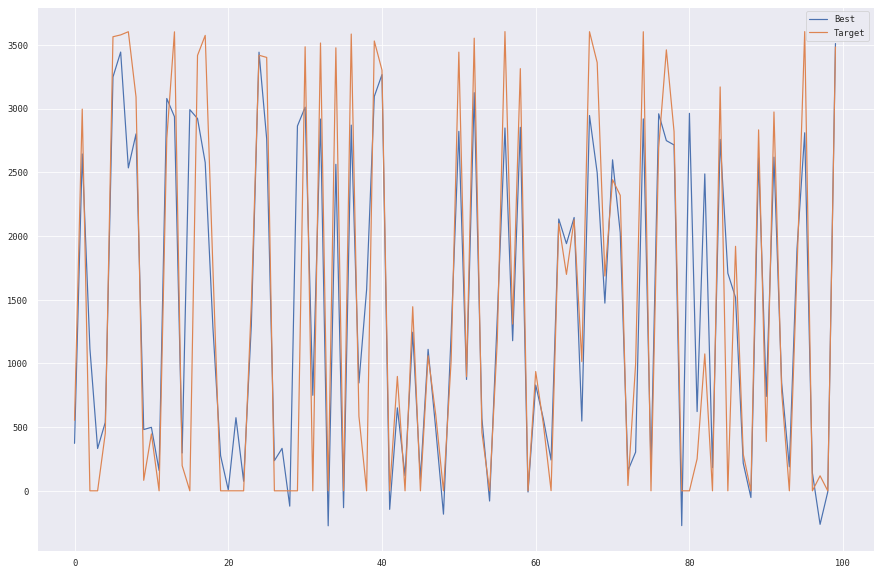

In [32]:
# Comparison of Target value vs Predicted values
dtr_table = pd.DataFrame({'Predict_values':y_pred_3,'Actual_values':y_test})
fig= plt.figure(figsize=(15,10))
predicting_vs_actual_dtr = dtr_table.reset_index()
predicting_vs_actual_dtr = predicting_vs_actual_dtr.drop(['index'],axis=1)
plt.plot(predicting_vs_actual_dtr[:100])
plt.legend(('Best', 'Target'))

### K Means

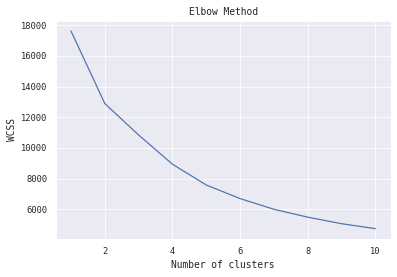

In [33]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
# plt.scatter(X[:,0], X[:,1])
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train, y_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [34]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit_predict(X_train, y_train)

#fig = plt.figure()
#ax = fig.add_subplot#(projection='2d')

#x_train = pd.DataFrame(X_train)
#ax.scatter(x_train.iloc[:,0], x_train.iloc[:,1], x_train.iloc[:,2])
#ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')

array([0, 0, 3, ..., 3, 2, 3], dtype=int32)

### Evaluation of Different models using Prediction Test

In [35]:
def prediction_print(x):
    print("Real Power Output : " + str(y_test.iloc[x]))    
    print("Predicted Power Output using Random Forest Regression : " + str(y_pred_1[x]))
    print("Predicted Power Output using Decision Tree Regression : " + str(y_pred_2[x]))
    print("Predicted Power Output using Linear Regression : " + str(y_pred_3[x]))  

In [36]:
prediction_print(21)

Real Power Output : 0.0
Predicted Power Output using Random Forest Regression : 135.33498819313792
Predicted Power Output using Decision Tree Regression : 76.288875578125
Predicted Power Output using Linear Regression : 573.9940694365295


### Decision Tree Classifier

In [37]:
A = data[["Theoretical_Power_Curve (KWh)","Wind speed (V)",]]
A.head()

,Theoretical_Power_Curve (KWh),Wind speed (V)
0,416.328908,5.311336
1,519.917511,5.672167
2,390.900016,5.216037
3,516.127569,5.659674
4,491.702972,5.577941


In [38]:
b = data["NAME"]
print("NAME")
b.head(10)

NAME


0    BLUE HILL LCD, MA US
1    BLUE HILL LCD, MA US
2    BLUE HILL LCD, MA US
3    BLUE HILL LCD, MA US
4    BLUE HILL LCD, MA US
5    BLUE HILL LCD, MA US
6    BLUE HILL LCD, MA US
7    BLUE HILL LCD, MA US
8    BLUE HILL LCD, MA US
9    BLUE HILL LCD, MA US
Name: NAME, dtype: object

In [39]:
data.groupby("NAME").count()

,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,WSF2,WSF5,LV ActivePower (kW),Wind speed (V),Theoretical_Power_Curve (KWh),Wind Direction (°),MONTH
NAME,,,,,,,,,,,,
"BEVERLY MUNICIPAL AIRPORT, MA US",327,327,327,327,327,327,327,327,327,327,327,327
"BLUE HILL LCD, MA US",183,183,183,183,183,183,183,183,183,183,183,183
"FITCHBURG MUNICIPAL AIRPORT, MA US",304,304,304,304,304,304,304,304,304,304,304,304
"HYANNIS BARNSTABLE MUNICIPAL AIRPORT, MA US",365,365,365,365,365,365,365,365,365,365,365,365
"LAWRENCE MUNICIPAL AIRPORT, MA US",365,365,365,365,365,365,365,365,365,365,365,365
"NANTUCKET MEMORIAL AIRPORT, MA US",350,350,350,350,350,350,350,350,350,350,350,350
"NEW BEDFORD MUNICIPAL AIRPORT, MA US",364,364,364,364,364,364,364,364,364,364,364,364
"PITTSFIELD MUNICIPAL AIRPORT, MA US",136,136,136,136,136,136,136,136,136,136,136,136
"VINEYARD HAVEN MARTHAS VINEYARD AIRPORT, MA US",360,360,360,360,360,360,360,360,360,360,360,360


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [41]:
A_train, A_test, b_train, b_test = train_test_split(A, b,test_size=0.2)
print("A_train shape {} and size {}".format(A_train.shape,A_train.size))
print("A_test shape {} and size {}".format(A_test.shape,A_test.size))
print("b_train shape {} and size {}".format(b_train.shape,b_train.size))
print("b_test shape {} and size {}".format(b_test.shape,b_test.size))

A_train shape (2203, 2) and size 4406
A_test shape (551, 2) and size 1102
b_train shape (2203,) and size 2203
b_test shape (551,) and size 551


In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
dtree = DecisionTreeClassifier(max_depth= 7, max_leaf_nodes= 50)
dtree.fit(A_train, b_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=50,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [44]:
y_predclass = dtree.predict(A_test)

In [45]:
y_predclass

array(['FITCHBURG MUNICIPAL AIRPORT, MA US', 'BLUE HILL LCD, MA US',
       'BEVERLY MUNICIPAL AIRPORT, MA US',
       'NEW BEDFORD MUNICIPAL AIRPORT, MA US',
       'VINEYARD HAVEN MARTHAS VINEYARD AIRPORT, MA US',
       'NEW BEDFORD MUNICIPAL AIRPORT, MA US',
       'NEW BEDFORD MUNICIPAL AIRPORT, MA US',
       'FITCHBURG MUNICIPAL AIRPORT, MA US',
       'FITCHBURG MUNICIPAL AIRPORT, MA US',
       'NEW BEDFORD MUNICIPAL AIRPORT, MA US',
       'VINEYARD HAVEN MARTHAS VINEYARD AIRPORT, MA US',
       'VINEYARD HAVEN MARTHAS VINEYARD AIRPORT, MA US',
       'NEW BEDFORD MUNICIPAL AIRPORT, MA US',
       'HYANNIS BARNSTABLE MUNICIPAL AIRPORT, MA US',
       'HYANNIS BARNSTABLE MUNICIPAL AIRPORT, MA US',
       'FITCHBURG MUNICIPAL AIRPORT, MA US', 'BLUE HILL LCD, MA US',
       'HYANNIS BARNSTABLE MUNICIPAL AIRPORT, MA US',
       'BEVERLY MUNICIPAL AIRPORT, MA US',
       'NEW BEDFORD MUNICIPAL AIRPORT, MA US',
       'FITCHBURG MUNICIPAL AIRPORT, MA US',
       'HYANNIS BARNSTABLE

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
print(classification_report(b_test, y_predclass))
print(confusion_matrix(b_test, y_predclass))


                                                precision    recall  f1-score   support

              BEVERLY MUNICIPAL AIRPORT, MA US       0.44      0.35      0.39        72
                          BLUE HILL LCD, MA US       0.14      0.08      0.10        36
            FITCHBURG MUNICIPAL AIRPORT, MA US       0.26      0.30      0.28        66
   HYANNIS BARNSTABLE MUNICIPAL AIRPORT, MA US       0.29      0.56      0.38        68
             LAWRENCE MUNICIPAL AIRPORT, MA US       0.14      0.04      0.06        80
             NANTUCKET MEMORIAL AIRPORT, MA US       0.23      0.07      0.11        67
          NEW BEDFORD MUNICIPAL AIRPORT, MA US       0.34      0.62      0.44        58
           PITTSFIELD MUNICIPAL AIRPORT, MA US       0.25      0.03      0.06        31
VINEYARD HAVEN MARTHAS VINEYARD AIRPORT, MA US       0.26      0.40      0.31        73

                                      accuracy                           0.29       551
                              

In [48]:
def prediction_print(x):
    print("Real Station Name : " + str(b_test.iloc[x]))    
    print("Predicted Station using Decison tree Classifier : " + str(y_predclass[x]))

In [49]:
prediction_print(10)

Real Station Name : NANTUCKET MEMORIAL AIRPORT, MA US
Predicted Station using Decison tree Classifier : VINEYARD HAVEN MARTHAS VINEYARD AIRPORT, MA US


In [50]:
prediction_print(13)

Real Station Name : HYANNIS BARNSTABLE MUNICIPAL AIRPORT, MA US
Predicted Station using Decison tree Classifier : HYANNIS BARNSTABLE MUNICIPAL AIRPORT, MA US
